In [ ]:
# torch
import torchvision
import torch
import random
import matplotlib.pyplot as plt

# paths
import os
import sys

# set paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import config

# my imports
from VOC_subset import VOCSubset
from utils import plot_bbox

# the lifesaver
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Sub-Section
This  will download the PASCAL VOC dataset to the `path_to_voc_` directory.

**!! Set download=true if you don't have the data !!**

In [ ]:
# path to store the dataset
path_to_voc = config.dataset_path

# load the PASCAL VOC dataset (VOC 2012), 
dataset = torchvision.datasets.VOCDetection(
    root=path_to_voc,
    year='2012',
    image_set='trainval', # get both
    download=False
)

This notebook will take a subset of the PASCAL VOC dataset containing images with a selected class. Images may include more than one class, but the interesting class is the one specified in `selected_class`.

In [8]:
selected_class_name = "cat"  
indices_file = f"VOC_{selected_class_name}_selected_indices.pth"

# toggle between loading and saving
SAVE = False

In [ ]:
if SAVE:
    selected_indices = []
    # scan the dataset and save
    for idx, (_, target) in enumerate(dataset):
        # get all objects
        annotations = target['annotation']['object']
        # get all the object names (for each object)
        class_ids = [obj['name'] for obj in annotations]
        # check if the selected class is in the annotations
        if selected_class_name in class_ids:
            selected_indices.append(idx)

    # Save indices to a file for faster access later
    torch.save(selected_indices, indices_file)
    print(f"Saved {len(selected_indices)} indices of images containing class '{selected_class_name}'")

else:
    # load from file
    selected_indices = torch.load(indices_file)
    print(f"Loaded {len(selected_indices)} indices of images containing class '{selected_class_name}'")

Saved 1084 indices of images containing class 'cat'


Check that we selected OK - all the images should include the selected class.

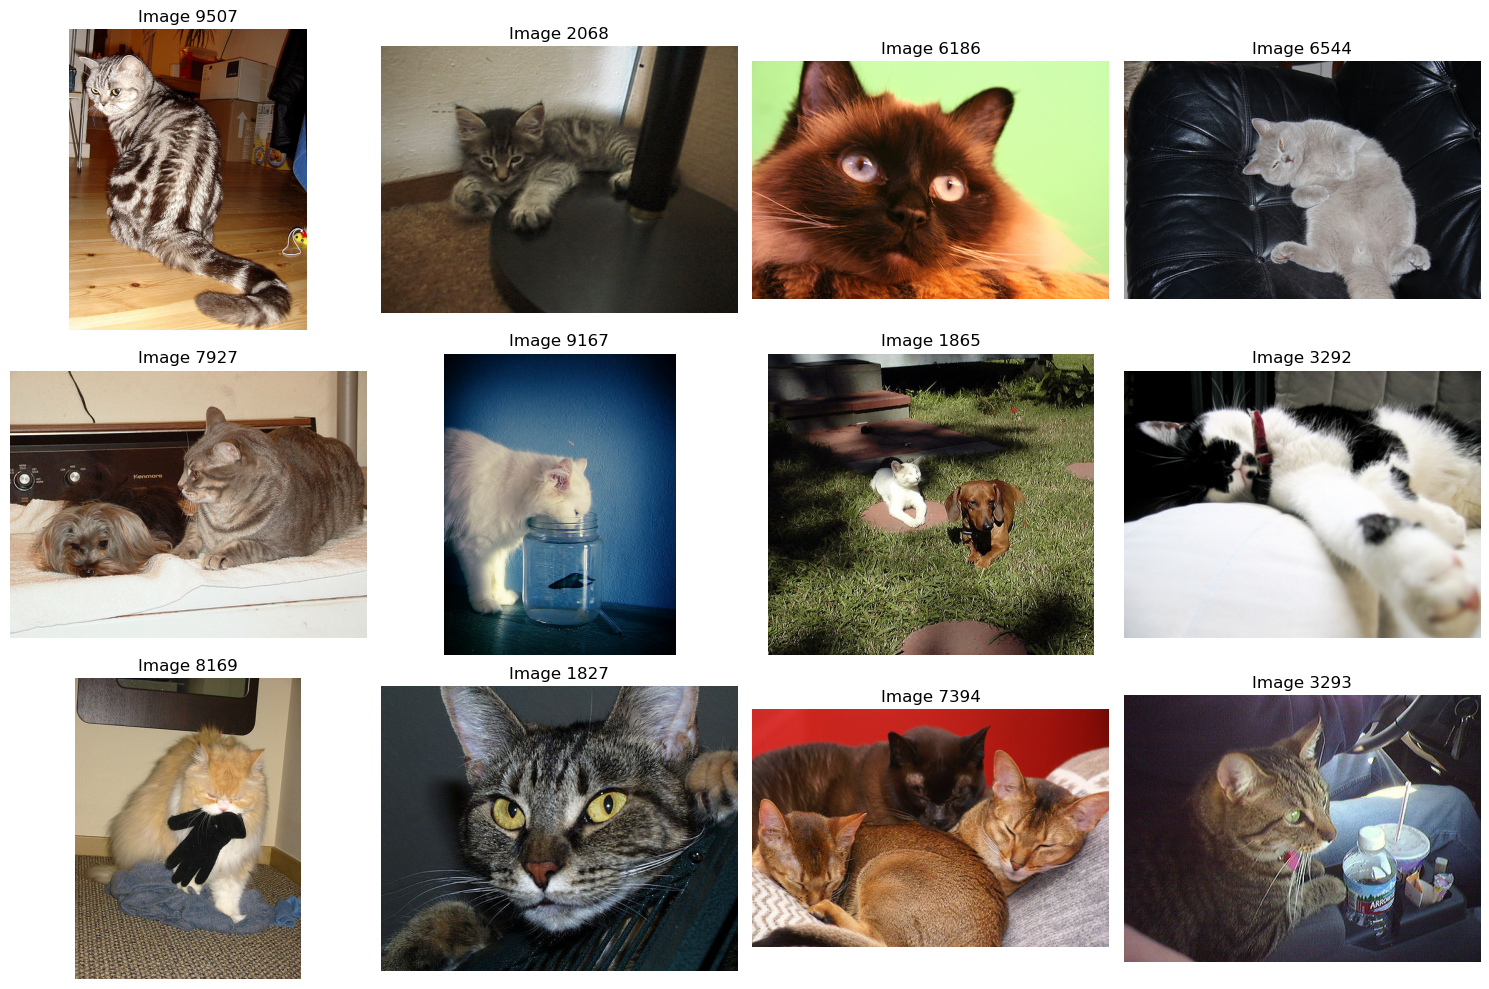

In [5]:
random_indices = random.sample(selected_indices, 12)

# Set up matplotlib figure
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

# Display the images
for i, idx in enumerate(random_indices):
    image, target = dataset[idx]
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Image {idx}")

# Show the plot
plt.tight_layout()
plt.show()

And also test by building a dataloader with single class. We also want to check that the image selector creates the correct bounding box around a **single** object only.

In [27]:
# build subset dataset
subsetDataset = VOCSubset(
    root=path_to_voc,
    indices_file = indices_file, 
    selected_class = selected_class_name,
    single_object = True,
    transform = None
)

assert (len(subsetDataset) == len(selected_indices))
print(f'Subset dataset loaded sucessfully, len = {len(subsetDataset)}')

Value(False)
Subset dataset loaded sucessfully, len = 1084


In [41]:
image, target = subsetDataset[3]

In [48]:
target['annotation']['object'][0]['bndbox']

{'xmin': '96', 'ymin': '124', 'xmax': '416', 'ymax': '375'}

TODO Move to helper function etc

In [ ]:
# Select 12 random indices from the dataset
random_indices = random.sample(range(len(subsetDataset)), 12)

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

# Display the images
for i, idx in enumerate(random_indices):
    image, target = subsetDataset[idx]
    
    # Get the bounding boxes for the selected class
    boxes = []
    for obj in target['annotation']['object']:
        if obj['name'] == dataset.selected_class:
            xmin = int(obj['bndbox']['xmin'])
            ymin = int(obj['bndbox']['ymin'])
            xmax = int(obj['bndbox']['xmax'])
            ymax = int(obj['bndbox']['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])

    # Draw the bounding boxes on the image
    image_with_boxes = draw_bounding_boxes(image, boxes, fill=True, colors="red", width=3)

    # Plot the image with bounding boxes
    axes[i].imshow(image_with_boxes.permute(1, 2, 0).numpy())
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Image {idx}")

# Show the plot
plt.tight_layout()
plt.show()